<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Quasi-Geostrophic Analysis</h1>
    <h3>MetPy for Quantitative Analysis of Meteorological Data</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Tasks
0. <a href="#import">Import required packages</a>
0. <a href="#narr">Access NARR Output</a>
0. <a href="#prep">Prepare data</a>
0. <a href="#terma">Compute Term A - Differential Vorticity Advection</a>
0. <a href="#termb">Compute Term B - Laplacian of Temperature Advection</a>
0. <a href="#4panel">Four Panel Plot</a>

This is a tutorial demonstrates common analyses for Synoptic Meteorology courses with use of Unidata tools, specifically [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/). In this tutorial we will cover accessing, calculating, and plotting model output.

### Background
Let's investigate [The Storm of the Century (1993)](https://en.wikipedia.org/wiki/1993_Storm_of_the_Century). This storm was massive, spanning most of North America's eastern seaboard. The eastern US and Canada received record snow accumulations (50"+ in the Blue Ridge Mountains and over 12" at Dulles and LaGuardia), ships in the Gulf of Mexico were sunk, and Florida saw several tornadoes and 10 foot storm surges. 

<img src="https://upload.wikimedia.org/wikipedia/commons/7/79/1993_storm_century.jpg"/>

The storm produced over $2 billion in damges. However, this event also was a turning point for operational forecasters who were able to identify this severe threat <b>five days</b> in advance. This was uprecedented lead time in 1993 and allowed for several states to call for a state of emergency even before snow started falling. 

This event shows us a textbook example of QG forcing. By examining reanalysis output, we can see very distinct regions of ascent and descent around the mature cyclone. 

### QG Omega Equation

Quasigeostrophic (QG) theory allows us to diagnose the processes leading to vertical air motion and the structural evolution of extratropical cyclones. Researchers and forecasters alike use the QG Omega equation to describe vertical air motion as it relates to synoptic-scale vorticity growth and decay. In this lesson, we will calculate the primary forcing terms for ascent using reanalysis output and MetPy analysis functions.  

Here is the QG Omega equation from Bluestein (1992; Eq. 5.6.11) with the two primary forcing terms on the right hand side of this equation. [More info](http://www.atmos.albany.edu/daes/atmclasses/atm401/PPTs-PDFs_files/qgomega-usersguide.pdf)

$$\left(\nabla_p ^2 + \frac{f^2}{\sigma}\frac{\partial ^2}{\partial p^2}\right)\omega = 
-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]
-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$

The first term on the right hand side, which we will call **Term A** describes **differential vorticity advection**. 

The second term on the right hand side, which we will call **Term B**, describes the **lapacian of temperature advection**. 

#### Goal
Calculate Term A and Term B at 700 hPa. 


<div class="alert alert-success">
    <b>EXERCISE</b>:
    Examine requirements
<ol>
    <li>Given the QG Omega equation above, what variables do we need from our data source? <a href="https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional" target="blank">North American Regional Reanalysis (NARR)</a></li>
    <li>Which <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.constants.html" target="blank">constants</a> are available in MetPy?</li>
    </ol>
</div>

In [1]:
# COMMENT YOUR RESPONSES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
    <ol>
    <li>Geopotential height (to calculate geostrophic wind) and temperature</li>
    <li>Dry gas constant, Rd</li>
    </ol>
</div>

<a name="import"></a>
### Step 0: Import required packages

In [2]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import xarray as xr

<a name="narr"></a>
### Step 1: Access NARR Output
NARR output is made available on a THREDDS Data Server (TDS) hosted by NCEI. 

https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional

We can use an NCSS query to access the remote data for our chosen storm. If you choose to use the 1993 Storm of the Century, that date will be March 13, 1993 at 1200Z

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 12

dt = datetime(year, month, day, hour)

From the [information page](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) on NCEI's website, we can select the [TDS](https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/catalog.html) link in the NARR-A table and see that the files are organized in the format:

`https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/<yearmonth>/<yearmonthday>/catalog.html`

We can use this structure to create a request for the file closest to the datetime `dt` of the storm of the century. We also replace .html with .xml to create the TDSCatalog object. 

We then use the `filter_time_nearest()` method on the datasets property of the catalog object to find the single dataset valid at the hour we specified above. 

In [4]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
tds_ds = cat.datasets.filter_time_nearest(dt)

#### NCSS query
Next, we set up access to request a subset of data from the file we've just identified using the NetCDF Subset Service (NCSS) on NCEI's TDS. 

NARR output contains [many variables](https://www.ncei.noaa.gov/thredds/ncss/model-narr-a-files/199303/19930313/narr-a_221_19930313_1200_000.grb/dataset.html). Instead of printing `ncss.variables` and listing all 100+ variable names, we can ask Python to only display variables that end with "isobaric". This suffix is how the TDS denotes GRIB fields that are specified on isobaric levels.

In [5]:
# Open a subset service on the tds_ds dataset
ncss = tds_ds.subset()

# Print the available variable names on isobaric surfaces
sorted(v for v in ncss.variables if v.endswith('isobaric'))

['Cloud_water_isobaric',
 'Geopotential_height_isobaric',
 'Horizontal_moisture_divergence_isobaric',
 'Ice_mixing_ratio_isobaric',
 'Pressure_Vertical_velocity_isobaric',
 'Specific_humidity_isobaric',
 'Temperature_isobaric',
 'Turbulent_Kinetic_Energy_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric']

Finally, we set up the NCSS query and get our data. Given the two variables we identified at the top of this notebook, we request only geopotential height and temperature on isobaric surfaces within our spatiotemporal bounds. 

In [6]:
# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.time(dt)
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

Next, open the data with xarray and parse it with MetPy for CF conventions, also assigning lat/lon values

In [7]:
# Open data with xarray, and parse it with MetPy
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data)).metpy.parse_cf()

# Assign latitude/longitude values to the dataset variables
ds = ds.metpy.assign_latitude_longitude()

<a name="prep"></a>
### Step 2: Prepare data
Since we are calculating QG omega at 700 hPa, we begin by selecting just the geopotential height and temperature at the 700 hPa level into an xarray DataArray. We can easily do this using xarray's `.sel()` method and MetPy's units inside the selection to ensure we are selecting the correct level.

Both terms A and B include a vertical pressure differential term, so we'll use the same method to also select the geopotential heights at the surrounding isobaric levels, 500 and 900 hPa.  

Since we used the NCSS to select a single time, we'll also use the `.squeeze()` method [(documentation)](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.squeeze.html) to remove the single-length time dimension, leaving us with a 2D DataArray. 

#### Select temperature and geopotential heights

In [8]:
# 700 hPa Temperature
tmpk_700 = ds['Temperature_isobaric'].metpy.sel(vertical = 700 * units.hPa).squeeze()

# 900, 700, 500 hPa Geopotential Height
hght_900 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 900 * units.hPa).squeeze()
hght_700 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 700 * units.hPa).squeeze()
hght_500 = ds['Geopotential_height_isobaric'].metpy.sel(vertical = 500 * units.hPa).squeeze()

# preview one of the new arrays
hght_700

<xarray.DataArray 'Geopotential_height_isobaric' (y: 119, x: 268)>
array([[3143.857, 3144.857, 3145.357, ..., 3155.357, 3155.857, 3155.857],
       [3142.357, 3143.357, 3144.357, ..., 3156.357, 3156.357, 3156.857],
       [3140.857, 3141.857, 3142.857, ..., 3156.857, 3157.357, 3157.357],
       ...,
       [2979.857, 2981.357, 2982.857, ..., 3139.857, 3142.357, 3143.857],
       [2977.357, 2979.357, 2980.857, ..., 3136.857, 3138.857, 3140.857],
       [2975.357, 2976.857, 2978.857, ..., 3133.857, 3135.857, 3138.357]],
      dtype=float32)
Coordinates:
    time1      datetime64[ns] 1993-03-13T12:00:00
    isobaric1  float32 700.0
  * y          (y) float32 -3.117e+06 -3.084e+06 ... 6.816e+05 7.141e+05
  * x          (x) float32 -3.324e+06 -3.292e+06 ... 5.311e+06 5.343e+06
    metpy_crs  object Projection: lambert_conformal_conic
    latitude   (y, x) float64 17.87 17.96 18.06 18.15 ... 35.07 34.85 34.64
    longitude  (y, x) float64 -135.0 -134.8 -134.5 ... -43.36 -43.13 -42.91
Attributes:
    long_name:           Geopotential height @ Isobaric surface
    units:               gpm
    description:         Geopotential height
    grid_mapping:        LambertConformal_Projection
    Grib_Variable_Id:    VAR_7-15-131-7_L100
    Grib1_Center:        7
    Grib1_Subcenter:     15
    Grib1_TableVersion:  131
    Grib1_Parameter:     7
    Grib1_Level_Type:    100
    Grib1_Level_Desc:    Isobaric surface

For calculation purposes we want to smooth our variables a little to get to the "synoptic values" from the higher resolution dataset we are using

In [9]:
# Number of repetitions of smoothing function
n_reps = 50

# Apply the 9-point smoother
hght_700s = mpcalc.smooth_n_point(hght_700, 9, n_reps)
hght_500s = mpcalc.smooth_n_point(hght_500, 9, n_reps)
hght_900s = mpcalc.smooth_n_point(hght_900, 9, n_reps)

tmpk_700s = mpcalc.smooth_n_point(tmpk_700, 9, n_reps)
tmpc_700s = tmpk_700s.metpy.convert_units('degC')

#### Calculate geostrophic wind

Our next step is to prepare for calculating the advection terms in the QG omega equation. Notice how in both terms A and B, the advection is done by the *geostrophic wind* rather than the total wind. Thus, we need to calculate the geostrophic wind, both the u and v components, next. 

<div class="alert alert-success">
    <b>EXERCISE</b>: Calculate u and v geostrophic wind
    
We can calculate the u and v components of the geostrophic wind from geopotential heights using the MetPy function <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.geostrophic_wind.html#metpy.calc.geostrophic_wind" target="blank">geostrophic_wind()</a>. This function outputs a tuple, (ug, vg). You can see a preview the syntax for using this function in the <a href="https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#calculations" target="blank">Xarray with MetPy</a> tutorial. 
    
Task: <br>
    Calculate the following variables. 
    
Variables:
     <ul>
         <li>ug_900s, vg_900s: 900-hPa Geostrophic Wind</li>
         <li>ug_700s, vg_700s: 700-hPa Geostrophic Wind</li>
         <li>ug_500s, vg_500s: 500-hPa Geostrophic Wind</li>
    </ul>
    
Hint: <br>
    Ignore any optional inputs in this calculation
</div>

In [10]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [11]:
# Calculate the geostrophic wind using the MetPy function
# mpcalc.geostrophic_wind
# 900-hPa Geostrophic Wind
ug_900s, vg_900s = mpcalc.geostrophic_wind(hght_900s)

# 700-hPa Geostrophic Wind
ug_700s, vg_700s = mpcalc.geostrophic_wind(hght_700s)

# 500-hPa Geostrophic Wind
ug_500s, vg_500s = mpcalc.geostrophic_wind(hght_500s)

#### Constants
Finally, we define the constants we need for the calculation of terms A and B.

In [12]:
# Set default static stability value
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')

# Set f-plane at typical synoptic f0 value
f0 = 1e-4 * units('s^-1')

# Use dry gas constant from MetPy constants
Rd = mpconstants.Rd

#### Summary

We have prepared the NARR dataset with the following 2D variables at time = 1993-03-13 12:00:

- temperature at 700 hPa
- geopotential height at 500, 700, and 900 hPa
- u and v components of geostrophic wind at 500, 700, and 900 hPa

We have also calculated or stored the following constants:
- $\sigma$
- $f$
- $R_d$

<a name="terma"></a>
### Step 3: Compute Term A - Differential Vorticity Advection

Recall our original task: Calculate Term A and Term B of the QG Omega Equation at 700 hPa. In this next step, we'll break down how to translate Term A (differential vorticity advection) from differential equation form to a calculation that can be make with the data we just prepared in Python. 

Here is Term A:

$$-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$

Recall that the right hand side of the QG Omega equation is the lapacian of $\omega$, which scales as -(-w), or positive vertical motion. Term A tells us that for cyclonic vorticity advection increasing with height, this term is positive, indicating forcing for ascent. 

We will approach this calculation from the inside out in this order: 
1. absolute vorticity at two levels (e.g., 500 and 900 hPa) $$\left(\zeta_g + f \right)$$
2. absolute vorticity advection at same two levels $$\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$
3. centered finite-difference between two levels (e.g., valid at 700 hPa )$$\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$
4. apply constants to calculate value of full term $$-\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[-\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right]$$

**NOTE:** By definition, the advection term in MetPy is calculated as (using temperature advection as an example) is:

$$-\vec{V} \cdot \nabla_p T$$

In [13]:
# 1. absolute vorticity at two levels (e.g., 500 and 900 hPa)
avor_900 = mpcalc.absolute_vorticity(ug_900s, vg_900s)
avor_500 = mpcalc.absolute_vorticity(ug_500s, vg_500s)

# 2. absolute vorticity advection at same two levels
vortadv_900 = mpcalc.advection(avor_900, ug_900s, vg_900s)
vortadv_500 = mpcalc.advection(avor_500, ug_500s, vg_500s)

# 3. centered finite-difference between two levels (e.g., valid at 700 hPa )
diff_avor = ((vortadv_900 - vortadv_500)/(400 * units.hPa).to_base_units())

# 4. apply constants to calculate value of full term
term_A = -(f0 / sigma.to_base_units() * diff_avor)

# Examine the units of Term A
print(term_A.data.units)

C:\Users\ncorbin\anaconda3\envs\metpy-workshop\lib\site-packages\metpy\xarray.py:1469: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  'Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.'


kilogram / meter ** 3 / second ** 3


#### Exploratory plot
Our natural tendency is to visually explore the output we just created. Let's now take a cursory look at the results on a simple plot.

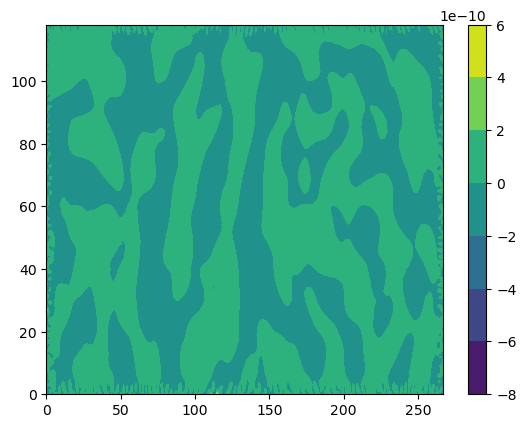

In [14]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
c = ax.contourf(term_A)
plt.colorbar(c)

<div class="alert alert-success">
    <b>Discussion</b>: 

There are a number of things in this exploratory plot that are unhelpful in understanding our output. What do you notice about the output? What are examples of things that we would want to change in a future iteration of this plot?

</div>

<div class="alert alert-info">
    <b>SOLUTION</b>

- There are indeed values, we didn't end up with zeros everywhere    
- Noise around the edges of the domain, an artifact of the model itself
- The scale of the values, 1e-10, we may want to scale this up for readability
- It's hard to distinguish positive and negative values, we may want to change the speciifc intervals of the contours
- No geographic context 
</div>

We will address these issues in our final plot, however, this exploratory plot explains why we will make the decisions we do in that final plot. 

<a name="termb"></a>
### Step 4: Compute Term B - Laplacian of Temperature Advection

The next task in our goal is to calculate Term B, the lapacian of temperature advection.

$$-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$

In this term, local maxima of warm advection result in positive values and thus, ascent. 

Using a similar method, we can calculate this term from the inside out. 

<div class="alert alert-success">
    <b>EXERCISE</b>: Compute Term B

Compute Term B using the same inside out method as previous
    
Tasks:
    
 <ol>
     <li>Temperature advection at 700 hPa (tadv_700) $$\left[-\vec{V_g} \cdot \nabla_p T \right]$$</li> 
     <li>Laplacian of Temp Adv. at 700 hPa (lap_tadv_700) $$\nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$</li>
     <li>Final term B with appropriate constants (term_B) $$-\frac{R}{\sigma p} \nabla_p ^2 \left[-\vec{V_g} \cdot \nabla_p T \right]$$</li>
     <li>Compare the output units of Term B with that of Term A</li>
</ol>
    
For information on how to calculate a Laplacian using MetPy, see the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.laplacian.html">documentation</a> on this function.
    
<b>STRETCH EXERCISE</b>: Term B Exploratory Plot

With your additional time, create an exploratory plot similar to what we demonstrated for Term A. What considerations may be needed in the final plot?
</div>

In [15]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [16]:
# Solution
# 1. Temperature advection at 700 hPa (tadv_700)
tadv_700 = mpcalc.advection(tmpc_700s, ug_700s, vg_700s)

# 2. Laplacian of Temp Adv. at 700 hPa (lap_tadv_700)
lap_tadv_700 = mpcalc.laplacian(tadv_700)

# 3. Final term B with appropriate constants (term_B)
term_B = -(Rd / (sigma * (700 * units.hPa)) * lap_tadv_700).metpy.convert_units(term_A.data.units)

# 4. Compare the output units of Term B with that of Term A
print(term_B.data.units)

C:\Users\ncorbin\anaconda3\envs\metpy-workshop\lib\site-packages\metpy\xarray.py:1469: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  'Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.'


kilogram / meter ** 3 / second ** 3


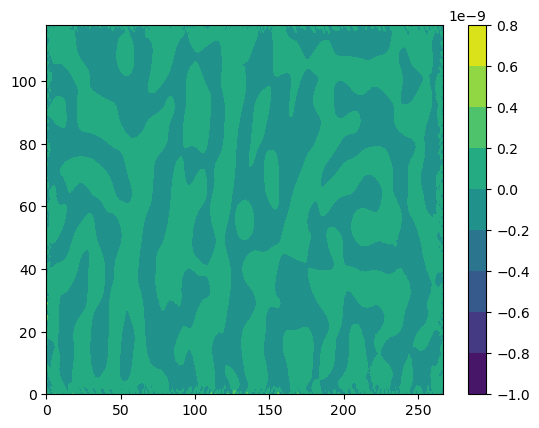

In [17]:
# Exploratory plot
fig = plt.figure()
ax = plt.subplot(1,1,1)
c = ax.contourf(term_B)
plt.colorbar(c)

<a name="4panel"></a>
### Step 5: Plot

Now we're ready to more fully examine the results of our calculations and present the information within context. The slides below describe the details of what we will prepare in our final 4-panel plot including the data scaling, geographic context, synoptic context, and final map surrounds. 

In [18]:
# Run this cell to view the widget
import ipywidgets as wg
from IPython.display import Image

w=800
def f(Slide):
    if Slide == 1:
        return Image(url='https://elearning.unidata.ucar.edu/metpy/QuantitativeAnalysisILT/QGnbGraphics/Slide1.png', width=w)
    elif Slide == 2:
        return Image(url='https://elearning.unidata.ucar.edu/metpy/QuantitativeAnalysisILT/QGnbGraphics/Slide2.png', width=w)
    elif Slide == 3:
        return Image(url='https://elearning.unidata.ucar.edu/metpy/QuantitativeAnalysisILT/QGnbGraphics/Slide3.png', width=w)
    elif Slide == 4:
        return Image(url='https://elearning.unidata.ucar.edu/metpy/QuantitativeAnalysisILT/QGnbGraphics/Slide4.png', width=w)
    else:
        return Image(url='https://elearning.unidata.ucar.edu/metpy/QuantitativeAnalysisILT/QGnbGraphics/Slide5.png', width=w)

wg.interact(f, Slide=wg.IntSlider(min=1,max=5,step=1));

interactive(children=(IntSlider(value=1, description='Slide', max=5, min=1), Output()), _dom_classes=('widget-…

In [19]:
# Prepare filled contours (omega and omega equation terms)

# scale terms by 10^11
term_A_scaled = term_A*10**11
term_B_scaled = term_B*10**11

# contour interval for omega and omega equation terms
clev_omega = np.arange(-5, 5.1, .5)

In [20]:
# Prepare geographic context

# Projection of the NARR data
dataproj = ds.Geopotential_height_isobaric.metpy.cartopy_crs

# Projection of the final plot
plotproj = ccrs.LambertConformal()

# Create x/y coordinate arrays of the same size as the data
x = ds.x
y = ds.y
xx, yy = np.meshgrid(x, y)

In [21]:
# Prepare synoptic context

# set height contour intervals (CINT)
# CINT 500 hPa Heights
clev_hght_500 = np.arange(0, 7000, 60)
# CINT 700 hPa Heights
clev_hght_700 = np.arange(0, 7000, 30)

# Set a barb skip interval; plot every 8th barb
barb_skip = (slice(None, None, 8), slice(None, None, 8))

#### Start 4-panel Figure

Text(1.0, 1.0, "VALID: ['1993-03-13 1200Z']")

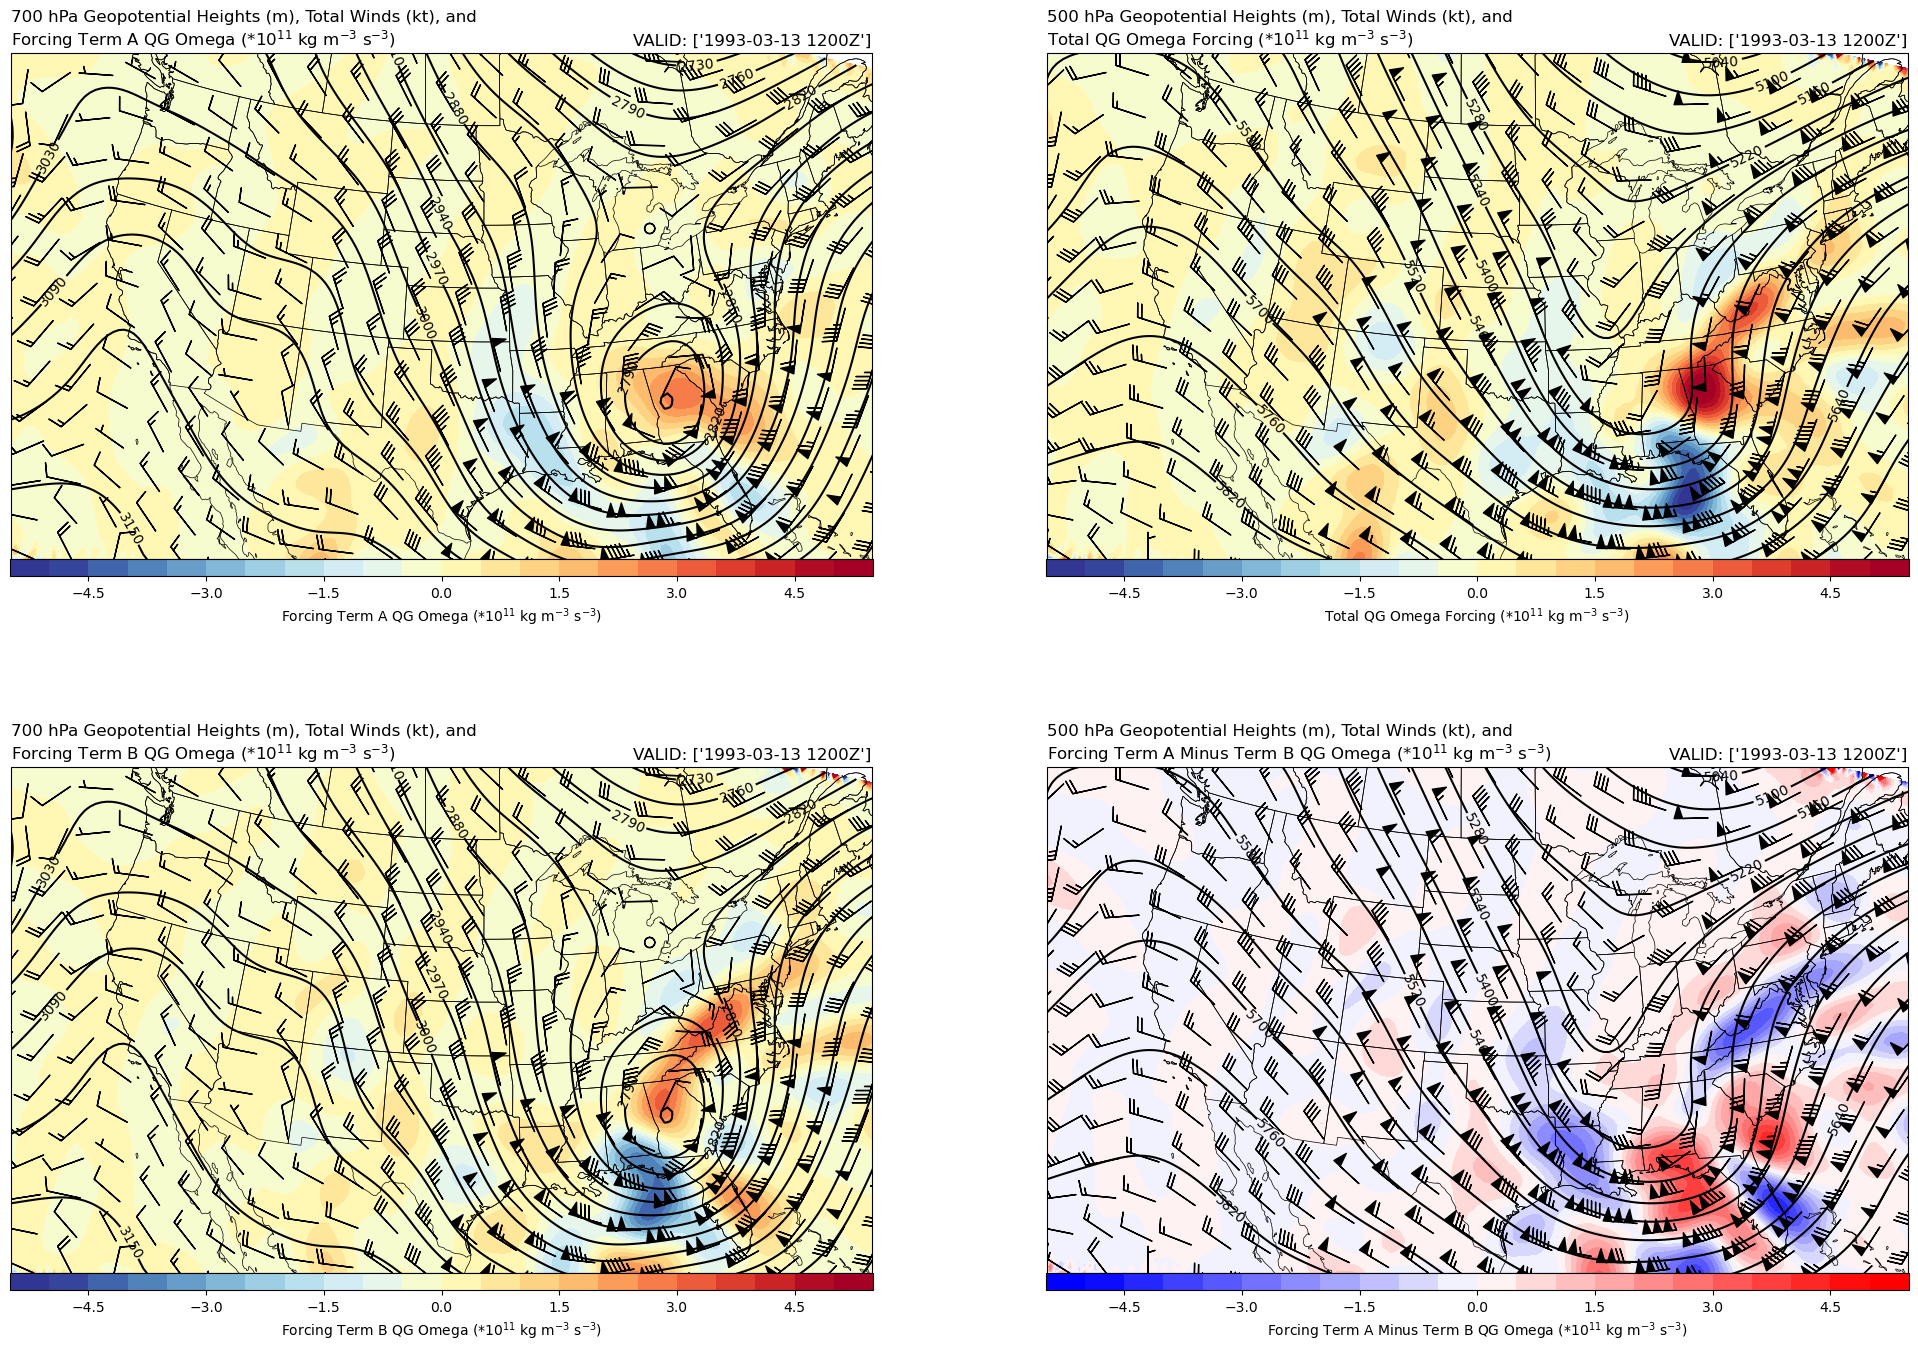

In [22]:
# Format the valid time for titles
vtime_str = str(ds.time1.dt.strftime('%Y-%m-%d %H%MZ').values)

# Set figure size
fig = plt.figure(1, figsize=(24.5,17.))

################################################################################
# Upper-Left Panel
ax=plt.subplot(2,2,1, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour: 700 hPa heights
cs = ax.contour(xx, yy, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled Contours: Term A scaled
cf = ax.contourf(xx, yy, term_A_scaled, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True, 
             label='Forcing Term A QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)')

# Barbs: Total Winds
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700 hPa Geopotential Heights (m), Total Winds (kt), and\n'
          'Forcing Term A QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

################################################################################
# Lower-Left Panel
ax=plt.subplot(2,2,3, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour: 700 hPa heights
cs = ax.contour(xx, yy, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled Contours: Term B scaled
cf = ax.contourf(xx, yy, term_B_scaled, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True, 
             label='Forcing Term B QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)')

# Barbs: Total Winds
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_700s.metpy.convert_units('kt').values[barb_skip],
         vg_700s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('700 hPa Geopotential Heights (m), Total Winds (kt), and\n'
          'Forcing Term B QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

################################################################################
# Upper-Right Panel
ax=plt.subplot(2,2,2, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour: 500 hPa heights
cs = ax.contour(xx, yy, hght_500s, clev_hght_500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled Contours: Term A scaled
cf = ax.contourf(xx, yy, (term_A_scaled+term_B_scaled), clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True, 
             label='Total QG Omega Forcing ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)')

# Barbs: Total Winds
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_500s.metpy.convert_units('kt').values[barb_skip],
         vg_500s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('500 hPa Geopotential Heights (m), Total Winds (kt), and\n'
          'Total QG Omega Forcing ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

################################################################################
# Lower-Right Panel
ax=plt.subplot(2,2,4, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour: 500 hPa heights
cs = ax.contour(xx, yy, hght_500s, clev_hght_500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Filled Contours: Term A - Term B scaled
cf = ax.contourf(xx, yy, (term_A_scaled-term_B_scaled), clev_omega,
                 cmap='bwr', extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True, 
             label='Forcing Term A Minus Term B QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)')

# Barbs: Total Winds
ax.barbs(xx[barb_skip], yy[barb_skip],
         ug_500s.metpy.convert_units('kt').values[barb_skip],
         vg_500s.metpy.convert_units('kt').values[barb_skip],
         transform=dataproj)

# Titles
plt.title('500 hPa Geopotential Heights (m), Total Winds (kt), and\n'
          'Forcing Term A Minus Term B QG Omega ($*10^{11}$ kg m$^{-3}$ s$^{-3}$)',loc='left')
plt.title(f'VALID: {vtime_str}', loc='right')

<div class="alert alert-success">
    <b>[OPTIONAL] EXERCISE</b>:
     
Modify one or more of the plots to display more information you are curious about, for example:
    <ul>
        <li>Change the combination of variables/levels in the plots</li>
        <li>Change the visual presentation of information (colormaps, contour styles)</li>
        <li>Add temperature contours</li>
        <li>Change one plot to show just temperature, heights, and winds.</li>
        <li>Change one plot to show just absolute vorticity (avor_500, avor_900), heights, and winds.</li>
    </ul>
</div>

In [23]:
# YOUR CODE GOES HERE

## More Information

### Further Practice
Project Pythia: Xarray Tutorial: https://foundations.projectpythia.org/core/xarray.html

Project Pythia: Cartopy Tutorial: https://foundations.projectpythia.org/core/cartopy.html

MetPy User Guide: https://unidata.github.io/MetPy/latest/userguide

MetPy Example Gallery: https://unidata.github.io/MetPy/latest/examples/index.html


### Save Your Work
<p>To save any of the files you modified or edited in this session:
    <ol>
        <li>Right click on any item in the left-side navigation pane</li>
        <li>Select <b>Download</b></li>
    </ol>
</p>

<p>
    To recreate the Conda environment used for this session on your local computer:
<ol>
	<li>
		Open a terminal (Linux or MacOS) or Anaconda Prompt (Windows). <br>
		Windows users: If Anaconda Prompt does not exist on your computer, Conda is not installed. Proceed with step 2.2.
	</li>
	<li>
		Confirm that Conda is installed by executing: <br>
		<b>conda --version</b>
		<ol>
			<li>
				If Conda is installed, a version number will be returned. Proceed to step 3.
			</li>
			<li>
				If Conda is not installed, proceed with the installation instructions provided for your operating system at <a href="https://unidata.github.io/python-training/#installing-conda" target="blank">this link</a>, then proceed to step 3.
			</li>
		</ol>
	</li>
	<li>
		Download the conda environment used in this workshop. On the link below, Shift + Right Click &gt; Save link as &gt; save the file as environment.yml in a location of your choosing.<br>
		<a href="https://raw.githubusercontent.com/Unidata/metpy-analysis/main/environment.yml">https://raw.githubusercontent.com/Unidata/metpy-analysis/main/environment.yml</a>
	</li>
	<li>
		In your terminal or command prompt, change directories to the location where the environment.yml file was saved. 
	</li>
	<li>
		Set up the course Python environment with the following command. <br>
		Note: this will take a few minutes to complete. <br>
		<b>conda env create -f environment.yml</b>
	</li>
	<li>
		Verify that the environment installed correctly by looking for <b>metpy-analysis</b> in your conda environment list <br>
		<b>conda env list</b>
	</li>
	<li>
		To use the new environment, activate the new environment<br>
		<b>conda activate metpy-analysis</b>
	</li>
	<li>
		Launch Jupyter Lab<br>
		<b>jupyter lab</b>
	</li>
</ol>
  
### Connect with Unidata
https://twitter.com/unidata

https://twitter.com/metpy

https://youtube.com/unidatanews

https://www.linkedin.com/company/unidatanews